In [8]:
import pykat
from pykat import finesse
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches

#import utils_DRFPMI as utl
   
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

In [9]:
# 1. Wikiに書いてある鏡間距離と曲率半径を書き込む
# FINESSEで微調整すれば少しずれることもあるが、発注する鏡はWikiに書いてあるものであり、微調整はできない。微調整は鏡の位相だけで行う。


# 2. アシンメトリなどを除去する
# まずは入射ビームのモードを腕に合わせる。
# そのために両腕のモードを揃えておく必要がある。
# 除去するのは、Schnuppアシンメトリと曲率誤差で、
# ロスインバランスは残してもよい。
# さらに、ウェッジ角と折り返し角も0度にしておく。
# この時点でミラーマップは入れない。cavコマンドは両腕のみ。

# 3. ビームパラメタを取得する(tuning1.kat)
# "trace 8"というコマンドラインを追加し、どんな計算でもいいからFINESSEを走らせると、各点でのビームプロファイルがログファイルに表示される。
# レーザーを設置した点でのプロファイルを見て、ウェスト位置とレイリーレンジを得る。
# プロファイルの向きがEOMからレーザーに向かっている場合は、ウェスト位置の符号が逆になることに注意。maxtemは5にしている。

## process 1-3


0: node nx2(21); ITMX(1), sx1(19); n=1  (ITMX --> nx2)
   x, y: w0=16.1969667343171mm w=35.3004705933891mm z=-1.5km z_R=774.596669241483m Rc=-1.9km
   q=(-1500 + 774.596669241483i) gamma=20.9101941403619urad
1: node nx3(22); sx1(19), ETMX(2); n=1  (sx1 --> nx3)
   x, y: w0=16.1969667343171mm w=35.3004705933891mm z=1.5km z_R=774.596669241483m Rc=1.9km
   q=(1500 + 774.596669241483i) gamma=20.9101941403619urad
2: node TMSX(23); ETMX(2), ---(-32768); n=1  (ETMX --> TMSX)
   x, y: w0=16.1969667343171mm w=35.3004705933891mm z=1.5km z_R=774.596669241483m Rc=1.9km
   q=(1500 + 774.596669241483i) gamma=20.9101941403619urad
3: node nx1(19); ITMX(1), lx(17); n=1  (ITMX --> nx1)
   x, y: w0=16.1969667343171mm w=35.3004705933891mm z=1.5km z_R=774.596669241483m Rc=1.9km
   q=(1500 + 774.596669241483i) gamma=20.9101941403619urad
4: node n3(17); lx(17), bs1(8); n=1  (lx --> n3)
   x, y: w0=16.1969667343171mm w=35.7657538225765mm z=1.52499995km z_R=774.596669241483m Rc=1.91844258585058km
   q=(1524.9

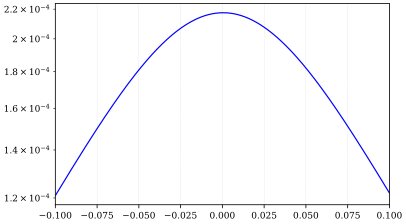

In [10]:
#Schnuppアシンメトリと曲率誤差を除去する。
#ロスインバランスは残してもよい。
#ウェッジ角と折り返し角も0度にしておく。
# この時点でミラーマップは入れない。
#n0のウェスト位置(z)とレイリーレンジ(z_R)を得る。

base = finesse.kat()
base.verbose=False
base.parse("""
    l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.3 3 pm 0.0 n_eo1 n_eo2
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.3 3 pm 0.0 n_eo3 n_eo4
    s s_eo2 0.0 n_eo4 REFL

    m PRM 0.8999550000000001 0.1 0.0 REFL npr1
    #m PRM 1.0 0.0 0.0 REFL npr1
    s sLpr1 14.7615 npr1 npr2
    bs PR2 1.0 0.0 0.0 0.0 npr3 npr2 POP POP2
    s sLpr2 11.0661 npr3 npr4
    bs PR3 1.0 0.0 0.0 0.0 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    bs bs1 0.5 0.5 0.0 45.0 npr6 n2 n3 n4
    s lx 24.99995 n3 nx1    #(26.6649+23.335)/2
    s ly 24.99995 n2 ny1    #(26.6649+23.335)/2
    m ITMX 0.995955 0.004 0.0 nx1 nx2
    s sx1 3000.0 nx2 nx3
    m ETMX 0.99995 5e-06 0.0 nx3 TMSX
    m ITMY 0.995955 0.004 90.0 ny1 ny2
    s sy1 3000.0 ny2 ny3
    m ETMY 0.99995 5e-06 90.0 ny3 TMSY
    
    s sLsr3 14.7412 n4 nsr5
    bs SR3 1 0 0.0 0 nsr5 nsr4 dump dump
    #bs SR3 0.999905 5e-05 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs SR2 1 0.0 0.0 0 nsr2 nsr3 POS dump
    #bs SR2 0.9994550000000001 0.0005 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    m SRM 0.8463550000000001 0.1536 0.0 nsr1 AS
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_AS AS
    pd0 pd0_DC_TMSX TMSX
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3


    """)
base.parse("""
### tuning
pd0 pd0_DC_TMSX TMSX #ETMx transmission
xaxis* ETMX phi lin -0.1 0.1 1000
yaxis lin abs
pause 3
trace 8
maxtem 5
""")
a = base.run()
print(a.rundata)

plt.figure(1)
plt.semilogy(a.x, a["pd0_DC_TMSX"])

plt.show()

## process 4

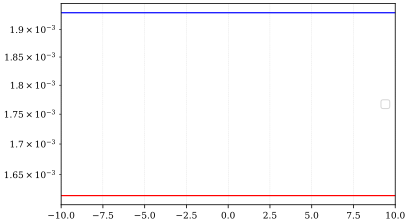

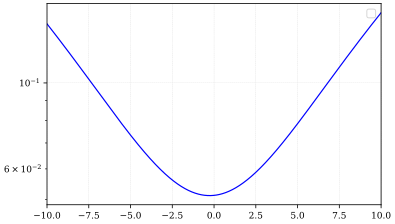

In [44]:
#　4. ミラーマップを入れて位相の調整① (tuning2.kat)
# 除去したアシンメトリや折り返し角を戻す。
# PRMとSRMの反射率をゼロにし、cavコマンドも両腕のみ。
# ミラーマップも入れて、まずはETMxとETMyの位相の調整を行う。(ITMのミラーとETMのミラーを入れた状態で、ETMを合わせる。)
# 腕の透過光が最大になるように各々の位相を合わせる。
# ETMxにのみミラーマップを入れた場合、ETMyの最適位相はゼロのはずである。
# BS の位相の調整は、SRM の透過光が最小になるようにして得る。このときETM に
# 上記の作業で得た位相を加えるのを忘れないこと。また、変調はOFF にしておく。


base = finesse.kat()
base.verbose=False
base.parse("""
    l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.3 3 pm 0.0 n_eo1 n_eo2
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.3 3 pm 0.0 n_eo3 n_eo4
    s s_eo2 0.0 n_eo4 REFL

    #m PRM 0.8999550000000001 0.1 0.0 REFL npr1
    m PRM 0 1.0 0.0 REFL npr1
    s sLpr1 14.7615 npr1 npr2
    bs PR2 1.0 0.0 0.0 0.686 npr3 npr2 POP POP2
    s sLpr2 11.0661 npr3 npr4
    bs PR3 1.0 0.0 0.0 0.686 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    #bs bs1 0.5 0.5 14.5 45.0 npr6 n2 n3 n4 #after tuning
    bs bs1 0.5 0.5 0 45.0 npr6 n2 n3 n4
    
    s lx 26.6649 n3 nx1 
    s ly 23.335 n2 ny1 

    m ITMX 0.995955 0.004 0.0 nx1 nx2
    s sx1 3000.0 nx2 nx3
    #m ETMX 0.99995 5e-06 0.025 nx3 TMSX # after tuning
    m ETMX 0.99995 5e-06 0.0 nx3 TMSX
    
    m ITMY 0.995955 0.004 90.0 ny1 ny2
    s sy1 3000.0 ny2 ny3
    #m ETMY 0.99995 5e-06 90.0 ny3 TMSY #after tuning #no change
    m ETMY 0.99995 5e-06 90.0 ny3 TMSY

    s sLsr3 14.7412 n4 nsr5
    bs SR3 1 0 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs SR2 1 0.0 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    m SRM 0 1.0 0.0 nsr1 AS
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_AS AS
    pd0 pd0_DC_TMSX TMSX
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3
    gauss* input i1 n0 -16.2049916742242 151.291549306146e-6

    trace 8
    maxtem 5
""")
base_x = base.deepcopy()
base_x.parse("""
    #x mirror map
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    ### tuning x-arm
    xaxis* ETMX phi lin -0.1 0.1 100
    yaxis lin abs
    pause 3
    
    """)

base_y = base.deepcopy()
base_y.parse("""
    ##y mirror map
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    ### tuning y-arm
    xaxis* ETMY phi lin -0.1 0.1 20
    yaxis lin abs
    pause 3
    
    """)
base_bs = base.deepcopy()
base_bs.parse("""
    #x mirror map
    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    ##y mirror map
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    ### tuning bs
    xaxis ITMX phi lin -10 10 1000
    put* ETMX phi $x1
    put* ITMY phi $mx1
    put* ETMY phi $mx1
    yaxis abs
    pause 3
    
    """)

a_x = base_x.run()
a_y = base_y.run()
a_bs = base_bs.run()

plt.figure(1)
plt.semilogy(a_x.x, a_x["pd0_DC_TMSX"])
plt.title('x_arm tuning')
plt.xlabel("x_arm tuning[deg]")
plt.ylabel("amplitude")

plt.figure(2)
plt.semilogy(a_y.x, a_y["pd0_DC_TMSY"])
plt.title('y_arm tuning')
plt.xlabel("y_arm tuning[deg]")
plt.ylabel("amplitude")

plt.figure(3)
plt.semilogy(a_bs.x, a_bs["pd0_DC_AS"])
plt.title('bs tuning')
plt.xlabel("bs tuning[deg]")
plt.ylabel("amplitude")

plt.show()

## process 5

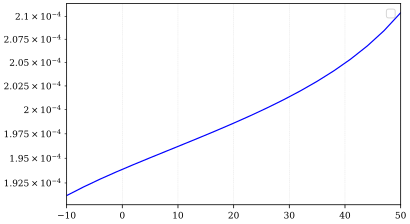

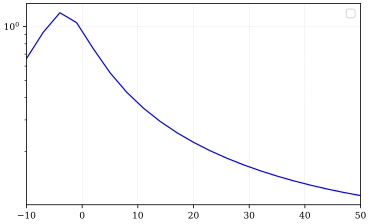

In [41]:
# 5. ミラーマップを入れて位相の調整② (tuning3.kat)
# PRMとSRMの反射率を元に戻し、PRCとSRCのcavコマンドを入れる。
# まず腕の透過光が最大になるようにPRMの位相を調整し、
# 次にadを用いて、腕を差動に振って生成した10kHzの信号が最大になるようにSRMの位相を調整する。
# このときの干渉計構成は、Broadband RSEであると考えられる。
# SRMの位相をこの状態からさらに3.5度ずらせばKAGRAが目指すDetuned RSEとなる。


base = finesse.kat()
base.verbose=False
base.parse("""
    l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.3 3 pm 0.0 n_eo1 n_eo2
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.3 3 pm 0.0 n_eo3 n_eo4
    s s_eo2 0.0 n_eo4 REFL

    m PRM 0.8999550000000001 0.1 0 REFL npr1
    #m PRM 0.8999550000000001 0.1 -5.0 REFL npr1 #after tuning
    s sLpr1 14.7615 npr1 npr2
    #bs PR2 0.9994550000000001 0.0005 0.0 0.686 npr3 npr2 POP POP2
    bs PR2 1.0 0.0 0.0 0.686 npr3 npr2 POP POP2
    s sLpr2 11.0661 npr3 npr4
    #bs PR3 0.999905 5e-05 0.0 0.686 dump dump npr4 npr5
    bs PR3 1.0 0.0 0.0 0.686 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    bs bs1 0.5 0.5 14.5 45.0 npr6 n2 n3 n4
    s lx 26.6649 n3 nx1 
    s ly 23.335 n2 ny1 
    
    m ITMX 0.995955 0.004 0.0 nx1 nx2
    s sx1 3000.0 nx2 nx3
    m ETMX 0.99995 5e-06 0.025 nx3 TMSX
    
    m ITMY 0.995955 0.004 90.0 ny1 ny2
    s sy1 3000.0 ny2 ny3
    m ETMY 0.99995 5e-06 90.0 ny3 TMSY
    
    s sLsr3 14.7412 n4 nsr5
    bs SR3 1 0 0.0 0.686 nsr5 nsr4 dump dump
    #bs SR3 0.999905 5e-05 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    bs SR2 1 0.0 0.0 0.686 nsr2 nsr3 POS dump
    #bs SR2 0.9994550000000001 0.0005 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    m SRM 0.8463550000000001 0.1536 0 nsr1 AS
    #m SRM 0.8463550000000001 0.1536 14.5(11+3.5) nsr1 AS  #(after tuning)
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3
    cav srcN SRM nsr1 ITMY ny1
    cav prcN PRM npr1 ITMX nx1
    gauss* input i1 n0 -16.2049916742242 151.291549306146e-6

    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    
    trace 8
    maxtem 5

    """)

base_prc = base.deepcopy()
base_prc.parse("""
    ### tuning PRC
    pd0 pd0_DC_TMSX TMSX
    xaxis* PRM phi lin -10 0.15 20
    yaxis lin abs
    pause 3
""")
base_ = base.deepcopy()
base_y.parse("""
    ### tuning SRC
    
    pd0 pd0_DC_TMSX TMSX
    fsig sig1 ETMX 10k 0
    fsig sig2 ETMY 10k 180
    ad pd 0 0 10k AS
    xaxis* SRM phi lin -10 50 20 
    yaxis lin abs
    pause 3
    
""")
a_p = base_prc.run()
a_s = base_src.run()
plt.figure(1)
plt.semilogy(a_p.x, a_p["pd0_DC_TMSX"])
plt.title('prc tuning')
plt.xlabel("prc tuning[deg]")
plt.ylabel("amplitude")

plt.figure(2)
plt.semilogy(a_s.x, a_s["pd"])
plt.title('src tuning')
plt.xlabel("src tuning[deg]")
plt.ylabel("amplitude")

plt.show()

### add Add transmittance and reflectance for PRC and SRC

No handles with labels found to put in legend.


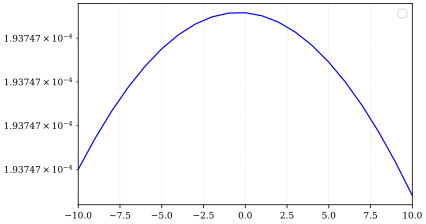

In [6]:
base = finesse.kat()
base.verbose=False
base.parse("""
    l i1 1.0 0.0 0.0 n0
    s s_eo0 0.0 n0 n_eo1
    mod eom1 16881000.0 0.3 3 pm 0.0 n_eo1 n_eo2
    s s_eo1 0.0 n_eo2 n_eo3
    mod eom2 45015900.0 0.3 3 pm 0.0 n_eo3 n_eo4
    s s_eo2 0.0 n_eo4 REFL

    #m PRM 0.8999550000000001 0.1 0 REFL npr1
    m PRM 0.8999550000000001 0.1 -5.0 REFL npr1 #after tuning
    s sLpr1 14.7615 npr1 npr2
    bs PR2 0.9994550000000001 0.0005 0.0 0.686 npr3 npr2 POP POP2
    #bs PR2 1.0 0.0 0.0 0.686 npr3 npr2 POP POP2
    s sLpr2 11.0661 npr3 npr4
    bs PR3 0.999905 5e-05 0.0 0.686 dump dump npr4 npr5
    #bs PR3 1.0 0.0 0.0 0.686 dump dump npr4 npr5
    s sLpr3 15.7638 npr5 npr6

    bs bs1 0.5 0.5 14.5 45.0 npr6 n2 n3 n4
    s lx 26.6649 n3 nx1 
    s ly 23.335 n2 ny1 
    
    m ITMX 0.995955 0.004 0.0 nx1 nx2
    s sx1 3000.0 nx2 nx3
    m ETMX 0.99995 5e-06 0.025 nx3 TMSX
    
    m ITMY 0.995955 0.004 90.0 ny1 ny2
    s sy1 3000.0 ny2 ny3
    m ETMY 0.99995 5e-06 90.0 ny3 TMSY
    
    s sLsr3 14.7412 n4 nsr5
    #bs SR3 1 0 0.0 0.686 nsr5 nsr4 dump dump
    bs SR3 0.999905 5e-05 0.0 0.686 nsr5 nsr4 dump dump
    s sLsr2 11.1115 nsr4 nsr3
    #bs SR2 1 0.0 0.0 0.686 nsr2 nsr3 POS dump
    bs SR2 0.9994550000000001 0.0005 0.0 0.686 nsr2 nsr3 POS dump
    s sLsr1 15.7386 nsr2 nsr1
    #m SRM 0.8463550000000001 0.1536 0 nsr1 AS
    m SRM 0.8463550000000001 0.1536 14.5 nsr1 AS  #(after tuning)
    
    pd0 pd0_DC_REFL REFL
    pd0 pd0_DC_AS AS
    pd0 pd0_DC_TMSX TMSX
    pd0 pd0_DC_TMSY TMSY
    pd0 pd0_DC_POP POP
    pd0 pd0_DC_POS POS

    
    # =========  HOM Expansion =======
    #attr bs1 Rc 0
    attr ITMX Rc -1900.   # measured -1904.6
    attr ETMX Rc 1900.    # measured  1908.24
    attr ITMY Rc -1900    # measured -1904.4
    attr ETMY Rc 1900.    # measured  1905.55
    
    # =========  from Somiya_example =======
    attr PRM Rc -458.1285 # given in MIF parameter list
    attr SRM Rc 458.1285 # given in MIF parameter list
    attr PR2 Rc -3.0764 # given in MIF parameter list
    attr PR3 Rc 24.9165 # given in MIF parameter list
    attr SR2 Rc -2.9872 # given in MIF parameter list
    attr SR3 Rc 24.9165 # given in MIF parameter list

    cav XARM ITMX nx2 ETMX nx3
    cav YARM ITMY ny2 ETMY ny3
    cav srcN SRM nsr1 ITMY ny1
    cav prcN PRM npr1 ITMX nx1
    gauss* input i1 n0 -16.2049916742242 151.291549306146e-6

    map ITMX ITMXhr.txt
    knm ITMX ITMXhrDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    conf ITMX knm_change_q 2
   
    map ITMX Apperture.txt
    knm ITMX ITMXabsDRFPMI2
    conf ITMX save_knm_binary 1
    conf ITMX interpolation_method 2
    conf ITMX integration_method 1
    
    
    map ETMX ETMXhr.txt
    knm ETMX ETMXhrDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1

    map ETMX Apperture.txt
    knm ETMX ETMXabsDRFPMI2
    conf ETMX save_knm_binary 1
    conf ETMX interpolation_method 2
    conf ETMX integration_method 1
    
    
    map ITMY Apperture.txt
    knm ITMY ITMYabsDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ITMY ITMYhr.txt
    knm ITMY ITMYhrDRFPMI2
    conf ITMY save_knm_binary 1
    conf ITMY interpolation_method 2
    conf ITMY integration_method 1

    map ETMY Apperture.txt
    knm ETMY ETMYabsDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1

    map ETMY ETMYhr.txt
    knm ETMY ETMYhrDRFPMI2
    conf ETMY save_knm_binary 1
    conf ETMY interpolation_method 2
    conf ETMY integration_method 1
    ### tuning PRC
    pd0 pd0_DC_TMSX TMSX
    xaxis* PRM phi lin -10 10 20
    yaxis lin abs
    pause
    ### tuning SRC
    
    /*
    pd0 pd0_DC_TMSX TMSX
    fsig sig1 ETMX 10k 0
    fsig sig2 ETMY 10k 180
    ad pd 0 0 10k AS
    xaxis* SRM phi lin -10 50 20 
    yaxis lin abs
    pause
    */
    

trace 8
maxtem 5
""")

base_prc = base.deepcopy()
base_prc.parse("""
    ### tuning PRC
    pd0 pd0_DC_TMSX TMSX
    xaxis* PRM phi lin -10 0.15 20
    yaxis lin abs
    pause 3
""")
base_ = base.deepcopy()
base_y.parse("""
    ### tuning SRC
    
    pd0 pd0_DC_TMSX TMSX
    fsig sig1 ETMX 10k 0
    fsig sig2 ETMY 10k 180
    ad pd 0 0 10k AS
    xaxis* SRM phi lin -10 50 20 
    yaxis lin abs
    pause 3
    
""")
a_p = base_prc.run()
a_s = base_src.run()
plt.figure(1)
plt.semilogy(a_p.x, a_p["pd0_DC_TMSX"])
plt.title('prc tuning')
plt.xlabel("prc tuning[deg]")
plt.ylabel("amplitude")

plt.figure(2)
plt.semilogy(a_s.x, a_s["pd"])
plt.title('src tuning')
plt.xlabel("src tuning[deg]")
plt.ylabel("amplitude")

plt.show()